In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


import random
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score


import warnings
import os
import sys


root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from utils.utils import *
from utils.constant import *

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
# Set a seed for reproducibility
np.random.seed(42)


In [2]:
file_path = get_absolute_path(
    'one_week.csv',
    'data',
    PROJECT_BASE_DIR
)

data = pd.read_csv(file_path)

In [3]:
data.columns

Index(['PRICE_SNAPSHOT_DATE', 'CATEGORY_LEVEL1', 'CATEGORY_LEVEL2',
       'CATEGORY_LEVEL3', 'MERCH_CLASSIFICATION1', 'MERCH_CLASSIFICATION2',
       'MERCH_CLASSIFICATION3', 'LIST_PRICE', 'RATING_AVG', 'RATING_CNT',
       'PRODUCT_PART_NUMBER', 'TOTAL_UNITS', 'TOTAL_CURRENT_ON_HAND',
       'NUM_DISTINCT_UNIQUE_VISIT_ID', 'TOTAL_DISTINCT_CUSTOMER_IDS',
       'TOTAL_HIT_NUMBER', 'RECORD_HIT_NUMBER'],
      dtype='object')

In [4]:
# Combine 'PRODUCT_CATEGORY_LEVEL1' and 'PRODUCT_CATEGORY_LEVEL3' into a new column
data['SEGMENT'] = data['CATEGORY_LEVEL1'] + ' - ' + data['MERCH_CLASSIFICATION3']


In [5]:
len(data)

120498

In [6]:
### Basic Information about the Datasets

# Display basic information about the dataset
print(data.info())

# Display summary statistics for numerical columns
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120498 entries, 0 to 120497
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   PRICE_SNAPSHOT_DATE           120498 non-null  object 
 1   CATEGORY_LEVEL1               120498 non-null  object 
 2   CATEGORY_LEVEL2               120498 non-null  object 
 3   CATEGORY_LEVEL3               120498 non-null  object 
 4   MERCH_CLASSIFICATION1         120498 non-null  object 
 5   MERCH_CLASSIFICATION2         120498 non-null  object 
 6   MERCH_CLASSIFICATION3         120498 non-null  object 
 7   LIST_PRICE                    104171 non-null  float64
 8   RATING_AVG                    120498 non-null  float64
 9   RATING_CNT                    120498 non-null  int64  
 10  PRODUCT_PART_NUMBER           120498 non-null  int64  
 11  TOTAL_UNITS                   120498 non-null  float64
 12  TOTAL_CURRENT_ON_HAND         120498 non-nul

In [8]:
print(len(data.SEGMENT.unique()))
data.SEGMENT.unique()

16


array(['Dog - Wet Food Toppings', 'Dog - Freeze-Dried Food',
       'Cat - Wet Food Toppings',
       'Cat - Freeze-Dried & Dehydrated Food Toppings',
       'Cat - Freeze-Dried Food', 'Dog - Dry Food', 'Cat - Dry Food',
       'Cat - Wet Food', 'Dog - Wet Food', 'Dog - Dehydrated Food',
       'Dog - Freeze-Dried & Dehydrated Food Toppings',
       'Cat - Dehydrated Food', 'Dog - Dry Food Toppings',
       'Dog - Frozen Food', 'Cat - Frozen Food',
       'Cat - Dry Food Toppings'], dtype=object)

# EM Algorithm / Gaussian Mixture Model for Anomaly Detection

3 Major Things to Pay Attention to:

1. Our data contains missing values (NaN), and the GaussianMixture algorithm does not handle missing values natively. To address this issue, we need to handle missing values (I just dropped the `NET_SALES` or `UNITS` records that contains missing values) in our data before fitting the model. 
2. Need to tune hyperparameter `n_components`.
3. Need to decide the `threshold`.

### GMM Anomaly Detection Optimization

- Hyperparameter Tuning
- Optimize the threshold

### Tuning `n_components`


Tuning the n_components parameter in Gaussian Mixture Models (GMMs) involves finding the optimal number of components (clusters) that best captures the underlying structure of your data. Here are a few methods you can use to determine the appropriate number of components:

1. Elbow Method:
    Fit GMMs with different values of n_components and plot the log-likelihood or another relevant metric against the number of components.
    Look for an "elbow" point where adding more components doesn't significantly improve the fit. This point is often considered a good choice for the number of clusters.

2. Silhouette Score:
    Calculate the silhouette score for different values of n_components. The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Higher silhouette scores indicate better-defined clusters.

3. AIC and BIC:
    Use the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) to evaluate different model fits. Lower values indicate better models.

4. Cross-Validation:
    Perform cross-validation with different values of n_components to assess the model's performance on unseen data.

Choose the number of components that maximizes the silhouette score, minimizes the AIC or BIC, or shows a prominent elbow point in the plots. 


In [12]:
metric_cols = [
    'LIST_PRICE', 'RATING_AVG', 'RATING_CNT'
    , 'TOTAL_UNITS', 'TOTAL_CURRENT_ON_HAND'
    # , 'NUM_DISTINCT_UNIQUE_VISIT_ID', 
    , 'TOTAL_DISTINCT_CUSTOMER_IDS'
    , 'RECORD_HIT_NUMBER'
]
metrics_data = data[metric_cols].dropna()
print(len(metrics_data))
print(len(data)-len(metrics_data))

104171
0


In [13]:
# Standardize the data
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics_data)


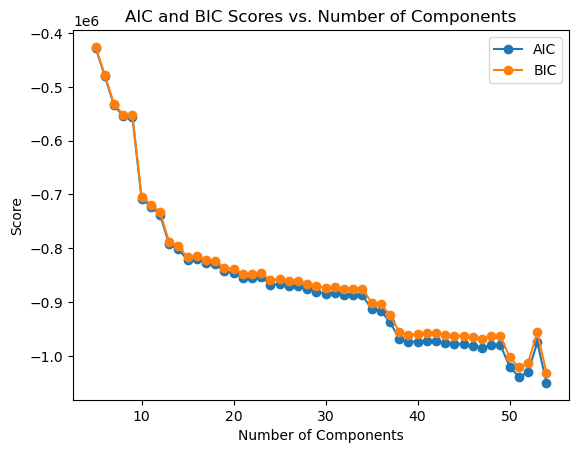

In [18]:
# AIC and BIC

n_components_range = range(5, 55)
best_gmm_model = None
lowest_bic = np.infty

# Calculate AIC and BIC scores
aic_scores = []
bic_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(metrics_scaled)
    aic_scores.append(gmm.aic(metrics_scaled))
    bic = gmm.bic(metrics_scaled)
    bic_scores.append(bic)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm_model = gmm

# Plot AIC and BIC scores
plt.plot(n_components_range, aic_scores, marker='o', label='AIC')
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('AIC and BIC Scores vs. Number of Components')
plt.legend()
plt.show()

# We can fine-tune the results later


In [19]:
best_gmm_model

GaussianMixture(n_components=54, random_state=42)

In [20]:
best_gmm_bic = best_gmm_model

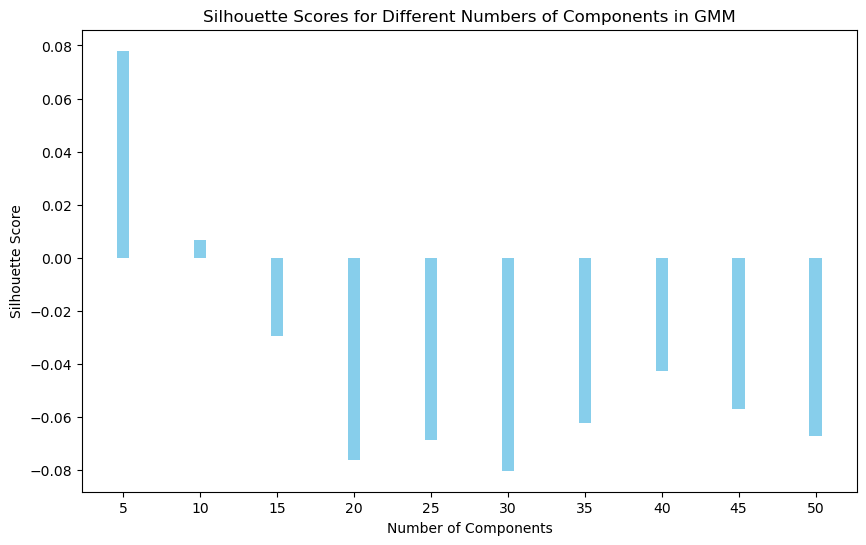

Optimal number of components based on silhouette score: 5


GaussianMixture(n_components=5, random_state=0)

In [24]:
## Using silhouette_scores

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Standardize the data
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics_data)

# Define a range for the number of components to be tested
n_components_range = range(5, 55, 5)
silhouette_scores = []

# Fit GMM models for each number of components and calculate the silhouette score
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    cluster_labels = gmm.fit_predict(metrics_scaled)
    silhouette_avg = silhouette_score(metrics_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores to visualize the decision
plt.figure(figsize=(10, 6))
plt.bar(n_components_range, silhouette_scores, color='skyblue')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Components in GMM')
plt.xticks(n_components_range)
plt.show()

# Determine the number of components with the highest silhouette score
optimal_n_components = n_components_range[np.argmax(silhouette_scores)]
print('Optimal number of components based on silhouette score:', optimal_n_components)

# Fit the GMM with the optimal number of components
best_gmm = GaussianMixture(n_components=optimal_n_components, covariance_type='full', random_state=0)
best_gmm.fit(metrics_scaled)

# Now you can use best_gmm for further analysis or to predict anomalies


In [25]:
best_gmm

GaussianMixture(n_components=5, random_state=0)

In [26]:
best_gmm_ss = best_gmm

In [ ]:
# # Fit the Gaussian Mixture Model
# gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
# gmm.fit(metrics_scaled)

# # Predict the probability of each data point belonging to each component
# probs = gmm.predict_proba(metrics_scaled)

# # Find the component with the smallest weight
# smallest_component = np.argmin(gmm.weights_)

# # Classify as an anomaly if the data point's highest probability is for the smallest component
# is_anomaly = probs[:, smallest_component] > 0.5

# # Extract the anomalies
# anomalies = metrics_data[is_anomaly]

# # Output the anomalies and their count
# print(anomalies)
# print('Number of anomalies detected:', len(anomalies))